This notebook compare WRF-Chem modeled surface pollutants with different minimm PBL coefficient mixing with ground based observations over Delhi NCT.

In [1]:
#import modules
%run ../load_main.py
from Air_Quality_notebooks import utils as utl
from WRFChemToolkit.analysis import statistics as st


## Load outputs  with different min mixing coefficients schemes

In [2]:
exchb=xr.open_mfdataset('/exports/geos.ed.ac.uk/palmer_group/managed/s1878599/delhiAQ/delhiNCT/outputs_postmon/pblmincoeff_tests/wrfout_d01_2019-10-*_00:00:00_nest_2019_newdyno_noexchmin.nc')
exch05= xr.open_mfdataset('/exports/geos.ed.ac.uk/palmer_group/managed/s1878599/delhiAQ/delhiNCT/outputs_postmon/pblmincoeff_tests/wrfout_d01_2019-10-*_00:00:00_nest_2019_newdyno_exchmin0.5.nc')
exch5=xr.open_mfdataset('/exports/geos.ed.ac.uk/palmer_group/managed/s1878599/delhiAQ/delhiNCT/outputs_postmon/pblmincoeff_tests//wrfout_d01_2019-10-*_00:00:00_nest_2019_newdyno_exchmin5.nc')
exch50=xr.open_mfdataset('/exports/geos.ed.ac.uk/palmer_group/managed/s1878599/delhiAQ/delhiNCT/outputs_postmon/pblmincoeff_tests/wrfout_d01_2019-10-*_00:00:00_nest_2019_newdyno_exchmin50.nc')

In [3]:
s={'exch_base':exchb,'exch_0.5':exch05, 'exch_5':exch5, 'exch_50':exch50}

In [4]:
def reset_time_dim(ds):
    """
    Time dimension in WRF-Chem datasets is just the time index [0,1,2,3...].
    This function convert dimension Time as datetime[64].
    :param ds:
     wrf-chem xarray dataset.
    :type ds:xarray.Dataset.
    :return:
     xarray.Dataset with datetime time dim.
    :rtype: xarray.Dataset.
    """
    return ds.assign_coords(Time=pd.to_datetime(ds.XTIME.values))

In [5]:
# reset time and discard 5 days  spinup period.
for k in s.keys():
    s[k]=reset_time_dim(s[k]).sel(Time=slice('2019-10-06T00:00:00.000000000','2019-10-16T00:00:00.000000000')) # 5 days

In [6]:
def gas_ppm_to_ugm3(ds,gas,mol_w):
    """Convert gas from ppmv to ug/m3 based on molar weight of gas
    from  https://www.acom.ucar.edu/wrf-chem/ConversionMozartWRFChem.pdf"""
    ds[gas + "_ugm3"]=((ds[gas]/1e6)*(mol_w/29)*1e9)/ds.ALT
    ds[gas + "_ugm3"].attrs["units"]="ug m-3"

# gas pollutants and their molar weight.
poll={"co":28,"o3":48,"no2":46,"so2":64,'no':30,'nh3':17} 
for v in s.values():
    for p,m in poll.items():
            gas_ppm_to_ugm3(v,p,m)

In [7]:
# subset surface values of relevant pollutants.

def get_pollutants(ds):
    
    data ={
           "no2" : (['time',"lat","lon"], ds.no2_ugm3.values[:,0,:,:]),
           "so2" : (['time',"lat","lon"], ds.so2_ugm3.values[:,0,:,:]),
           "o3" : (['time',"lat","lon"], ds.o3_ugm3.values[:,0,:,:]),
           "nh3" : (['time',"lat","lon"], ds.nh3_ugm3.values[:,0,:,:]),
           'nox': (['time',"lat","lon"], ds.no.values[:,0,:,:]*1e3+ds.no2.values[:,0,:,:]*1e3),  # from  ppmv to ppb.
           "no" : (['time',"lat","lon"], ds.no_ugm3.values[:,0,:,:]),
           "pm25" : (['time',"lat","lon"], ds.PM2_5_DRY.values[:,0,:,:]),             
           "pm10" : (['time',"lat","lon"], ds.PM10.values[:,0,:,:]),
           "PBLH" : (['time',"lat","lon"], ds.PBLH.values[:,:,:]),
          }
    coords={'time': (['time'], ds.XTIME[:]),'lat': (['lat'], ds.XLAT[0,:,0]), 'lon': (['lon'], ds.XLONG[0,0,:])}
    p = xr.Dataset(data, coords=coords)
    return p

p={}
for k,v in s.items():
    p.update({k:get_pollutants(v)})

#put in a dictionary 
mod={'exch_base':p['exch_base'],'exch_0.5':p['exch_0.5'], 'exch_5':p['exch_5'], 'exch_50':p['exch_50']}
mod_all={'exch_base':p['exch_base'],'exch_0.5':p['exch_0.5'], 'exch_5':p['exch_5'], 'exch_50':p['exch_50']}

In [8]:
# extract Delhi NCT data only
from WRFChemToolkit.analysis import aerosols_202 as aer, plots as pt, statistics as st
import salem
shp = '/exports/csce/datastore/geos/users/s1878599/phd_work/DelhiNCT/gadm_data/delhiNCT/delhiNCT.shp'

for k,v in mod.items():
    mod[k]= mod[k].salem.roi(shape=shp)

## Load observations data over NCT

In [10]:
# load observations data
pth ='../observations/cpcb_oct2019_cleaned.xlsx'  # new downloaded direclty from CPCB website.
data=pd.read_excel(pth)

In [11]:
# add utc time to observations
from datetime import timedelta
data['date_UTC'] = pd.to_datetime(data['date_UTC'], format='%Y-%m-%d %H:%M:%S')
#select observation corresponding to model output time range (UTC)
data_new=data.set_index('date_UTC')[str(mod['exch_5'].time.min().values):str(mod['exch_5'].time.max().values)].reset_index()  

In [12]:
data_new.date_UTC.max()

Timestamp('2019-10-16 00:00:00')

In [13]:
#create dict with datasets with dyno mean and std (local time)
obs={}
pol=['pm25','o3','nox']
for p in pol:
    df = data_new[['hour_LT',p]].groupby('hour_LT').agg({'mean', 'std'})[p].add_prefix(p + "_obs_").reset_index()
    obs.update({p:df})

## Definition of metrics and plot functions

In [14]:
import scipy.stats as ss
import statsmodels.api as sm
import numpy as np

def len_err(x,y):
    if len(x) != len(y):
        raise Exception("Number of observation datapoints is different from number of model datapoints.")


def get_MB(o,m):
    "Calculate the mean bias from model and observation. m and o are array of model and observations."
    len_err(o,m)
    return sum(m-o)/len(o)

def get_NMB(o,m):
    "Normalised mean bias"
    len_err(o,m)
    return sum(m-o)/sum(o)

def get_RMSE(o,m):
    "Normalised mean bias"
    len_err(m,o)
    return (sum((m-o)**2)/len(o))**0.5

def get_NMAE(o,m):
    "Normalised mean absolute error"
    len_err(o,m)
    return sum(abs(m-o))/sum(o)

def get_r(o,m):
    import scipy.stats as ss
    "pearson coefficient and p value"
    len_err(o,m)
    return ss.pearsonr(o,m)

def get_fit(o,m):
    "linear regression slope values"
    model = sm.OLS(m, o)
    ln=model.fit()
    return ln.params

In [15]:
# create dataframe where to save metrics
metr = pd.DataFrame(columns= ["pollutant","pbl_scheme","NMB","NMAE","MB [ug/m3]","RMSE [ug/m3]","r"])
metr['pbl_scheme'] =['exch_base']+['exch_0.5']+['exch_5']+['exch_50']
metr['pollutant'] = ["pm25"]*4
metr= metr.sort_values(["pollutant",'pbl_scheme'])

In [16]:
metr

,pollutant,pbl_scheme,NMB,NMAE,MB [ug/m3],RMSE [ug/m3],r
1,pm25,exch_0.5,NaN,NaN,NaN,NaN,NaN
2,pm25,exch_5,NaN,NaN,NaN,NaN,NaN
3,pm25,exch_50,NaN,NaN,NaN,NaN,NaN
0,pm25,exch_base,NaN,NaN,NaN,NaN,NaN


In [17]:
import matplotlib.pyplot as plt
def plot_avg_Delhi_ax_multi(mod_dict,df_o,spc,ax):
    
    ax.errorbar(df_o['hour_LT'],df_o[spc+'_obs_mean'],fmt='o-',alpha=0.75,markersize=8, label = "OBS")
   
    for k in mod_dict.keys():
        df_m=mod_dict[k][spc]
        ax.errorbar(df_m['hour'],df_m['mod_'+spc+'_mean'],markersize=8,label = k)
    
        ax.set_ylabel('$\mu g~m^{-3}$',fontsize=12)
        
        ax.legend(loc=[1.05,0.25],fontsize=12)

    
    # shadows errors
    ax.fill_between(df_o['hour_LT'], df_o[spc+'_obs_mean']+ df_o[spc+'_obs_std'], df_o[spc+'_obs_mean']- df_o[spc+'_obs_std'],alpha=0.3)
    
    #plt.style.use('seaborn-darkgrid')

# Compare model vs observations at stations 

In [18]:
#data: create dict with datasets with dyno mean and std in Local Time
data['date_LT'] = pd.to_datetime(data['date_LT'], format='%Y-%m-%d %H:%M:%S')
data['hour']=data['date_LT'].dt.hour
#select observation corresponding to model output time range (UTC)
data_new=data.set_index('date_UTC')[str(mod['exch_5'].time.min().values):str(mod['exch_5'].time.max().values)].reset_index()  
dyno_st=data_new.groupby(['station','hour']).mean().reset_index()

In [19]:
#model: create datasets with dyno mean and std in Local Time by station
from datetime import timedelta
mod_latlon={'exch_base':{},'exch_0.5':{},'exch_5':{},'exch_50':{}}
for k in mod_latlon.keys():
    print(k)
    temp={}
    for v in mod_all[k].data_vars:
        df = mod_all[k][v].to_dataframe().reset_index()
        # get local time
        df['date_LT'] = df['time'] +timedelta(hours=5.5) # son 5.5 hr
        df['hour'] = df['date_LT'].dt.hour
        df.drop('time',axis=1, inplace=True)
       
        # groupby hour
        df=df.groupby(['lat','lon','hour']).agg({'mean', 'std'})[v].add_prefix(v + "_")
        temp.update({v:df.to_xarray()})
    mod_latlon.update({k: temp})

exch_base
exch_0.5
exch_5
exch_50


In [20]:
# subset model outputs to correspond to  observation (lat,lon)

In [21]:
mod_n={'exch_base':{},'exch_0.5':{},'exch_5':{},'exch_50':{}}
po=['pm25']
for t in mod_latlon.keys():
    o=dyno_st.copy()
    for k in po:  # POLL loop over pollutants df in observations.
    
        o["mod_time"]=0.0
        o["mod_lat"]=0.0   # add columns to store model data
        o["mod_lon"]=0.0 
        o["mod_"+k]=0.0 
        o["mod_pblh"]=0.0
        o["mod_"+k+'_std']=0.0
        
        da = mod_latlon[t][k]
        for idx, row in o.iterrows():# get model values row by row
            #da = mod[row["season"]][k] # select relevant data array based on season and pollutant
            m = da.sel( # get model gridpoint closest to obs lat lon(nearest method) 
                   lat=row["lat"],
                   lon=row["lon"],
                   method='nearest') 
            m=m.sel(hour=row['hour'])  #get only times in the data.
            o["mod_time"][idx]=str(m.hour.values)
            o["mod_lat"][idx]=float(m.lat) # save lat, lon and pollutant value as separate columns
            o["mod_lon"][idx]=float(m.lon)
            o["mod_"+k][idx]=float(m[k+'_mean'])
            o["mod_"+k+'_std'][idx]=float(m[k+'_std'])
       
    # add pblh
            da_pb = mod_latlon[t]['PBLH']
            m_pb = da_pb.sel( # get model gridpoint closest to obs lat lon(nearest method) 
                  lat=row["lat"],
                   lon=row["lon"],
                   method='nearest') 
            m_pb=m_pb.sel(hour=row['hour'])  #get only times in the data.
            o['mod_pblh'][idx]=float(m_pb['PBLH_mean'])  
    mod_n[t]=o

In [22]:
#create dict with datasets with dyno mean and std in Local Time
from datetime import timedelta
mod_comp={}
for t in mod_latlon.keys():
    d={}
    for v in po:
        # grupby hour
        dfo=mod_n[t].groupby('hour').agg({'mean', 'std'})[v].add_prefix(v + "_").reset_index()
        dfm=mod_n[t].groupby('hour').agg({'mean', 'std'})['mod_'+v].add_prefix('mod_'+v + "_").reset_index()
        d.update({v:pd.merge(dfo,dfm)})
    mod_comp[t]=d

In [23]:
# Calculate metrics for each pollutant and each season
for s in mod_latlon.keys():
    print(s)
    for k,v in mod_comp[s].items(): # loop over pollutants df in observations.                      
        o=mod_comp[s][k][k+'_mean'].apply(np.array)     # get array of observations and values by season
        m=mod_comp[s][k]['mod_'+k+'_mean'].apply(np.array)
        metr.loc[(metr.pbl_scheme == s) & (metr.pollutant==k),"MB [ug/m3]"] =get_MB(o,m) 
        metr.loc[(metr.pbl_scheme == s) & (metr.pollutant==k), "NMB"] = get_NMB(o,m) 
        metr.loc[(metr.pbl_scheme== s) & (metr.pollutant==k), "RMSE [ug/m3]"] = get_RMSE(o,m)
        metr.loc[(metr.pbl_scheme == s) & (metr.pollutant==k), "NMAE"] = get_NMAE(o,m) 
        metr.loc[(metr.pbl_scheme == s) & (metr.pollutant==k), "r"] =get_r(o,m)[0]

exch_base
exch_0.5
exch_5
exch_50


pm25


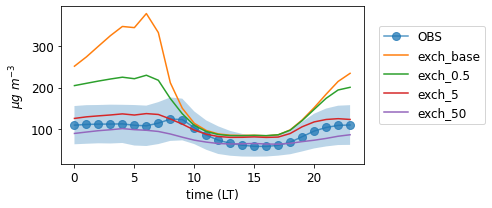

In [24]:
# plot

fig, axes = plt.subplots(1,1,figsize=(7,3))
for p,ax in zip(['pm25'],fig.axes):
    print(p)
    plot_avg_Delhi_ax_multi(mod_comp,obs[p],p,ax)
    
for ax in fig.axes:
#   if  ax==fig.axes[7]  or ax==fig.axes[6]:
    ax.set_xlabel('time (LT)', fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
#    else:
#        ax.xaxis.set_ticklabels([])

#fig.delaxes(fig.axes[])
fig.tight_layout()


In [25]:
#fig.savefig('./figS2.pdf', format='pdf', dpi=300)